In [32]:
import numpy as np
from PIL import Image
from copy import deepcopy
from typing import Optional, Tuple
import tritonclient.grpc as grpcclient
import matplotlib.pyplot as plt

### Preprocess and postprocess at client

In [26]:
class OnnxInference:
    def __init__(self, image: np.ndarray, model_img_size: int = 1024):
        self.image = image
        self.original_size = image.shape[:2]
        self.model_img_size = model_img_size
        self.old_h, self.old_w = image.shape[0], image.shape[1]
        self.pixel_mean = np.array([123.675, 116.28, 103.53]).reshape(1, 1, -1)
        self.pixel_std =  np.array([58.395, 57.12, 57.375]).reshape(1, 1, -1)
        self.get_preprocess_shape()
        
    def get_preprocess_shape(self) -> None:
        scale = self.model_img_size * 1.0 / max(self.old_h, self.old_w)
        new_h, new_w = self.old_h * scale, self.old_w * scale
        self.new_h = int(new_h + 0.5)
        self.new_w = int(new_w + 0.5)
    
    def padding(self, image: np.ndarray) -> np.ndarray:
        image = (image - self.pixel_mean) / self.pixel_std
        padded_image = np.zeros((image.shape[0], self.model_img_size, self.model_img_size, 3), dtype=np.float32)
        padded_image[0, :self.new_h, :self.new_w, :] = image[0, :, :, :]
        return padded_image
        
    def preprocessing_image_encoder(self) -> np.ndarray:
        image = Image.fromarray(self.image).resize((self.new_w, self.new_h))
        image = np.array(image)[None, :, :, :]
        image = self.padding(image)
        image = np.transpose(image, (0, 3, 1, 2))
        return image
    
    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (self.new_w / self.old_w)
        coords[..., 1] = coords[..., 1] * (self.new_h / self.old_h)
        return coords

    def preprocessing_prompt_encoder(self, input_point: np.ndarray, 
                                     input_label: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        
        input_point = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
        point_labels = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
        point_coords = self.apply_coords(input_point).astype(np.float32)
        return point_coords, point_labels
    
    def select_masks(self, masks: np.ndarray, scores: np.ndarray, 
                     num_points: int) -> Tuple[np.ndarray, np.ndarray]:
        
        score_reweight = np.array([[1000] + [0] * 3])
        score = scores + (num_points - 2.5) * score_reweight
        best_index = np.argmax(scores, axis=1)
        masks = masks[np.arange(masks.shape[0]), best_index, :, :][:, None, :, :]
        scores = scores[np.arange(masks.shape[0]), best_index][:, None]
        return masks, scores
    
    def resizing(self, images: np.ndarray, width, height) -> np.ndarray:
        images = Image.fromarray(images[0, 0])
        images = images.resize((width, height), Image.BILINEAR)
        return np.array(images)[None, None, :, :]
    
    def postprocessing(self, masks: np.ndarray) -> np.ndarray:
        masks = self.resizing(masks, self.model_img_size, self.model_img_size) 
        masks = masks[..., : self.new_h, : self.new_w]
        masks = self.resizing(masks, self.old_w, self.old_h)
        return masks

### Inference at server with GRPC

In [27]:
class TritonClient:
    def __init__(self, image):
        self.url = "localhost:8001"
        self.client = grpcclient.InferenceServerClient(url=self.url)
        self.onnx_infer = OnnxInference(image)
        self.image_embedding = self.image_encoder()
        
    def image_encoder(self):
        preprocessed_image = self.onnx_infer.preprocessing_image_encoder()
        input_image_encoder = [grpcclient.InferInput("input", preprocessed_image.shape, "FP32")]
        input_image_encoder[0].set_data_from_numpy(preprocessed_image)
        
        image_embedding = [grpcclient.InferRequestedOutput("output")]
        response = self.client.infer(model_name="image_encoder", inputs=input_image_encoder, outputs=image_embedding)
        image_embedding = response.as_numpy("output")
        return image_embedding
    
    def prompt_encoder(self, input_point, input_label, input_mask, has_input_mask):
        self.point_coords, point_labels = self.onnx_infer.preprocessing_prompt_encoder(input_point, input_label)
        input_prompt_encoder = [
            grpcclient.InferInput("point_coords", self.point_coords.shape, "FP32").set_data_from_numpy(self.point_coords),
            grpcclient.InferInput("point_labels", point_labels.shape, "FP32").set_data_from_numpy(point_labels),
            grpcclient.InferInput("input_mask", input_mask.shape, "FP32").set_data_from_numpy(input_mask),
            grpcclient.InferInput("has_input_mask", has_input_mask.shape, "FP32").set_data_from_numpy(has_input_mask)
        ]
        output_prompt_encoder = [
            grpcclient.InferRequestedOutput("sparse_embedding"),
            grpcclient.InferRequestedOutput("dense_embedding")
        ]
        response = self.client.infer(model_name="prompt_encoder", inputs=input_prompt_encoder, outputs=output_prompt_encoder)
        self.sparse_embedding = response.as_numpy("sparse_embedding")
        self.dense_embedding = response.as_numpy("dense_embedding")
    
    def mask_decoder(self):
        input_mask_decoder = [
            grpcclient.InferInput("image_embedding", self.image_embedding.shape, "FP32").set_data_from_numpy(self.image_embedding),
            grpcclient.InferInput("sparse_embedding", self.sparse_embedding.shape, "FP32").set_data_from_numpy(self.sparse_embedding),
            grpcclient.InferInput("dense_embedding", self.dense_embedding.shape, "FP32").set_data_from_numpy(self.dense_embedding),
        ]
        output_mask_decoder = [
            grpcclient.InferRequestedOutput("masks"),
            grpcclient.InferRequestedOutput("scores")
        ]
        response = self.client.infer(model_name="mask_decoder", inputs=input_mask_decoder, outputs=output_mask_decoder)
        self.masks = response.as_numpy("masks")
        self.scores = response.as_numpy("scores")
                
    def inference(self, input_point, input_label, input_mask, has_input_mask):
        
        self.prompt_encoder(input_point, input_label, input_mask, has_input_mask)
        self.mask_decoder()
        selected_masks, _ = self.onnx_infer.select_masks(self.masks, self.scores, self.point_coords.shape[1])
        upscaled_masks = self.onnx_infer.postprocessing(selected_masks)
        return upscaled_masks

In [28]:
# input from users
image = np.array(Image.open("inputs/truck.jpg"))
input_point = np.array([[800, 575]])
input_label = np.array([1])
input_mask = np.zeros((1, 1, 256, 256), dtype=np.float32)
has_input_mask = np.zeros(1, dtype=np.float32)

# Triton client inference
triton_client = TritonClient(image)

In [29]:
masks = triton_client.inference(input_point, input_label, input_mask, has_input_mask)
masks = masks > 0.0

### Visualization

In [33]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

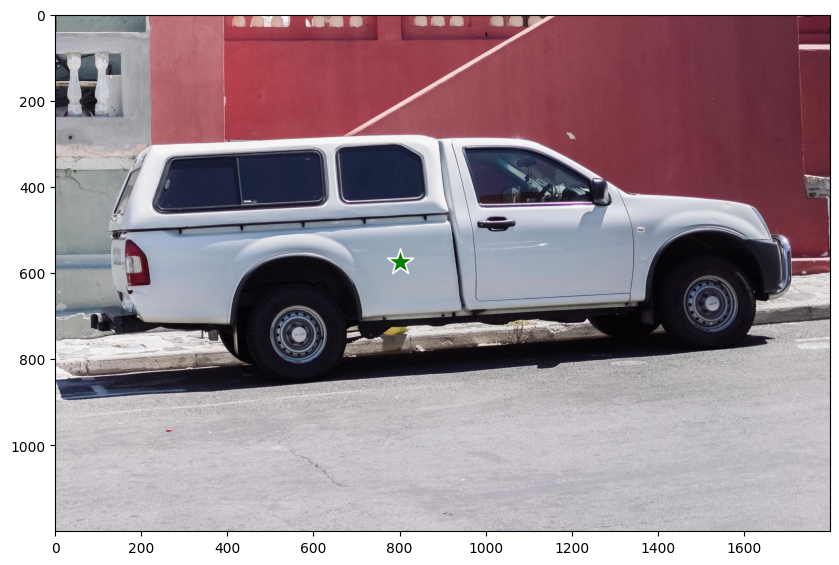

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

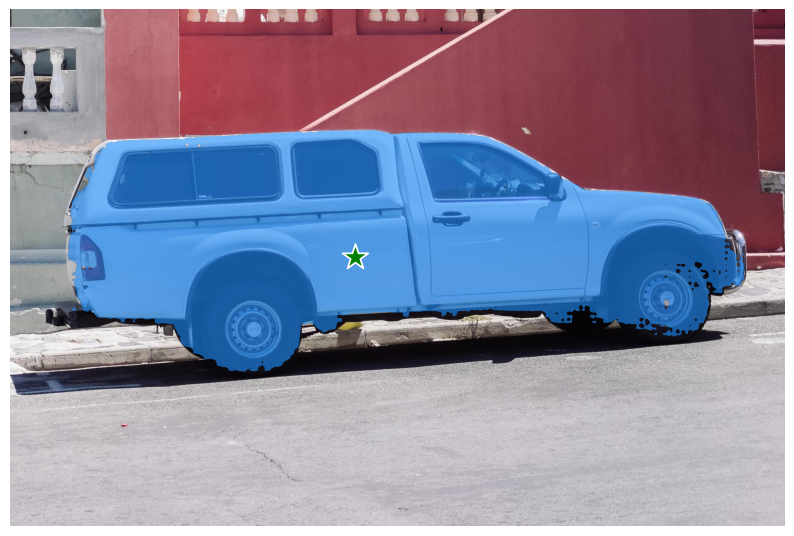

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 